In [162]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, PolynomialFeatures, KBinsDiscretizer, QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import transformers
from transformers import EarlyStoppingCallback
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset, DatasetDict


In [100]:
df = pd.read_csv("/kaggle/input/fake-news-classification/WELFake_Dataset.csv")

In [101]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [102]:
df.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [104]:
df.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [105]:
df = df.fillna('')

In [106]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [107]:
print(df['label'].value_counts())

label
1    37106
0    35028
Name: count, dtype: int64


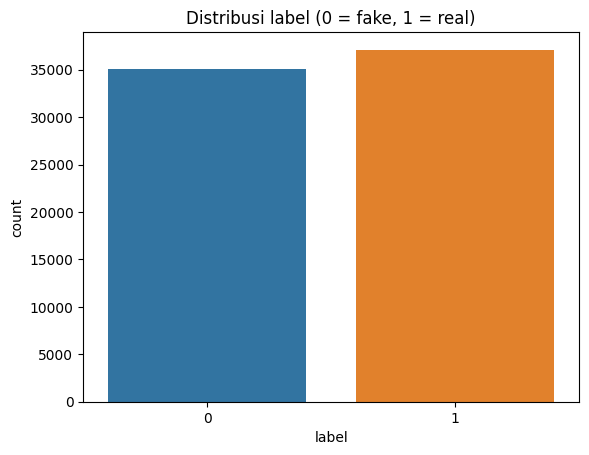

In [108]:
sns.countplot(x='label', data=df)
plt.title("Distribusi label (0 = fake, 1 = real)")
plt.show()

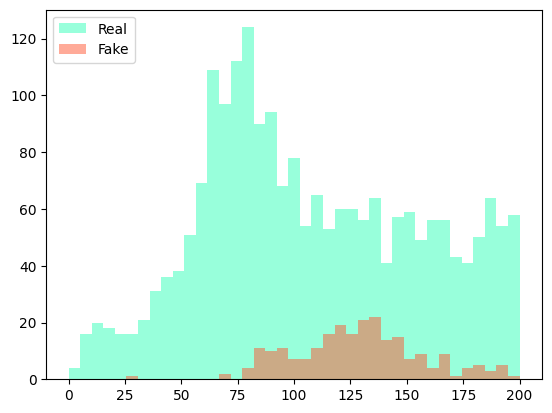

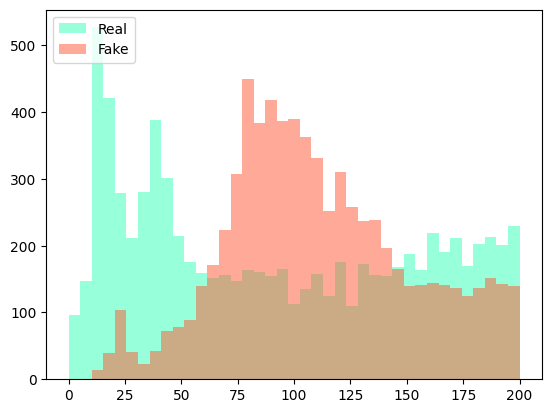

In [109]:
df["title_text"] = df["title"] + df["text"]
df['text_len'] = df["title_text"].apply(lambda x: len(x) - x.count(" "))
df['word_count'] = df["title_text"].apply(lambda x: len(str(x).split(" ")))
bins = np.linspace(0, 200, 40)
plt.hist(df[df["label"]== 1]["text_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["text_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()
plt.hist(df[df["label"]== 1]["word_count"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.hist(df[df["label"]== 0]["word_count"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.legend(loc="upper left")
plt.show()

# Text Preprocessing

In [110]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))

    clean_tokens = []
    for token in tokens:
        if token not in stop_words:
            clean_tokens.append(token)

    return " ".join(clean_tokens)

# Title

In [111]:
y_title = df['label']
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(df['title'], y_title, test_size=0.2, random_state=53)

## Wordcloud

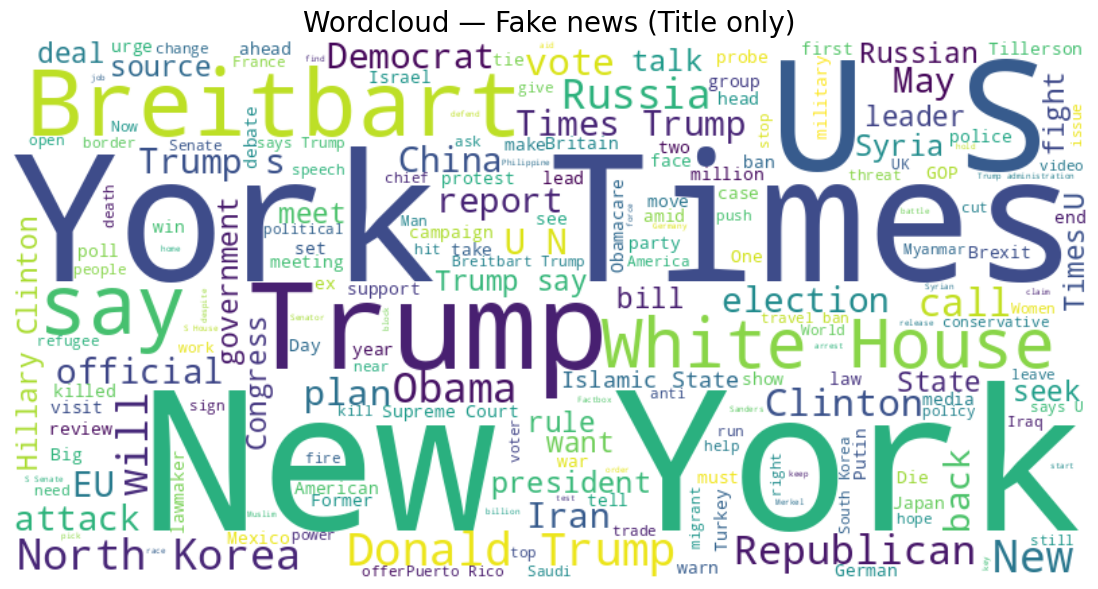

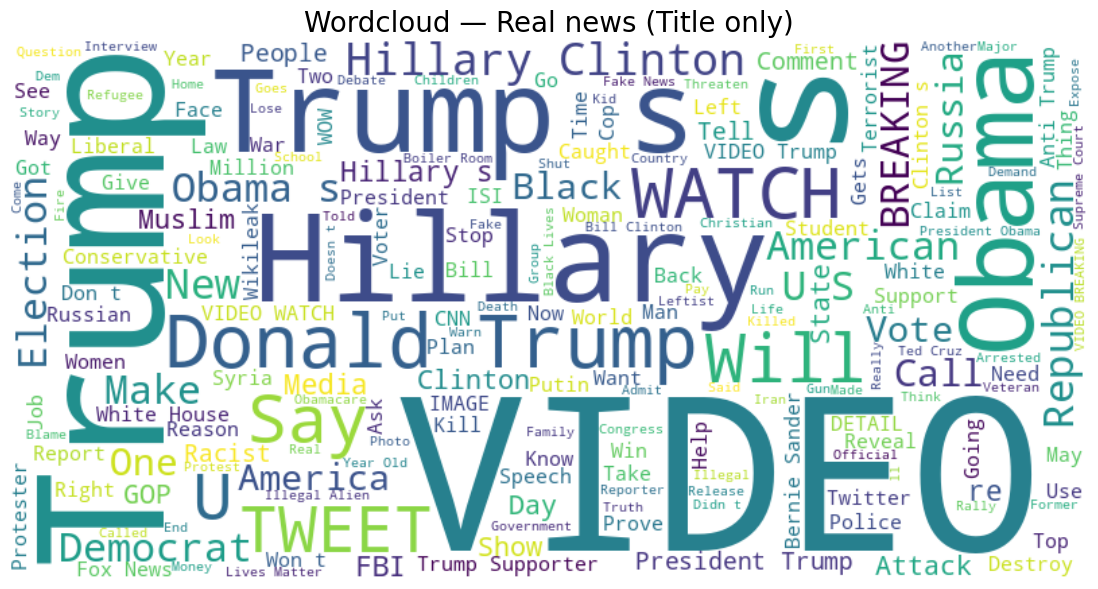

In [112]:
for label, name in [(0, "Fake"), (1, "Real")]:
    text = " ".join(str(txt) for txt in X_train_title[y_train_title==label])
    wc = WordCloud(stopwords=STOPWORDS,
                   width=800, height=400,
                   background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Wordcloud — {name} news (Title only)", fontsize=20)
    plt.axis('off')
    plt.show()

## TF-IDF Title

In [113]:
X_train_title = [text_preprocessing(text) for text in X_train_title]
X_test_title = [text_preprocessing(text) for text in X_test_title]

In [114]:
tfidf_title = TfidfVectorizer(
    stop_words='english',
    max_features=5000,     
    ngram_range=(1,2)      
)

tfidf_train_title = tfidf_title.fit_transform(X_train_title)
tfidf_test_title = tfidf_title.transform(X_test_title)

### 100% Data Train

In [115]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_title, y_train_title)
    
y_pred = Logistic.predict(tfidf_test_title)

print("Logistic Regression Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 100% data): 0.8928398142371942


In [116]:
nb = MultinomialNB()
nb.fit(tfidf_train_title, y_train_title)
    
y_pred_nb = nb.predict(tfidf_test_title)
print("Naive Bayes Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_nb))

Naive Bayes Accuracy (trained on 100% data): 0.8707978096624385


In [117]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_title, y_train_title)

y_pred_rf = rf.predict(tfidf_test_title)
print("Random Forest Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 100% data): 0.898177029181396


In [118]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_title, y_train_title)

y_pred_xgb = xgb.predict(tfidf_test_title)
print("XGBoost Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 100% data): 0.8285159769875927


In [119]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_title, y_train_title)

y_pred_vote = voting.predict(tfidf_test_title)
print("Soft Voting Accuracy (trained on 100% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 100% data): 0.9031676717266237


#### Evaluasi

In [120]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8928398142371942
Precision: 0.8929690297987924
Recall   : 0.8928398142371942
F1-score : 0.8927998493963217

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7043
           1       0.89      0.91      0.90      7384

    accuracy                           0.89     14427
   macro avg       0.89      0.89      0.89     14427
weighted avg       0.89      0.89      0.89     14427


=== Naive Bayes Metrics ===
Accuracy : 0.8707978096624385
Precision: 0.8709127398062908
Recall   : 0.8707978096624385
F1-score : 0.8707479901391559

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      7043
           1       0.87      0.88      0.88      7384

    accuracy                           0.87     14427
   macro avg       0.87      0.87      0.87     14427
weighted avg       0.87      0.87      0.87  

### 50% Data Train

In [121]:
tfidf_train_title_50, _, y_train_title_50, _ = train_test_split(
    tfidf_train_title, 
    y_train_title, 
    train_size=0.5,
    random_state=42,
    stratify=y_train_title
)

In [122]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_title_50, y_train_title_50)

y_pred = Logistic.predict(tfidf_test_title)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 50% data): 0.8839675608234561


In [123]:
nb = MultinomialNB()
nb.fit(tfidf_train_title_50, y_train_title_50)
    
y_pred_nb = nb.predict(tfidf_test_title)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_nb))

Naive Bayes Accuracy (trained on 50% data): 0.868163859430235


In [124]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_title_50, y_train_title_50)

y_pred_rf = rf.predict(tfidf_test_title)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 50% data): 0.8791848617176128


In [125]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_title_50, y_train_title_50)

y_pred_xgb = xgb.predict(tfidf_test_title)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.8238025923615443


In [126]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_title_50, y_train_title_50)

y_pred_vote = voting.predict(tfidf_test_title)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.8919387259998613


#### Evaluasi

In [127]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8839675608234561
Precision: 0.8844566933183695
Recall   : 0.8839675608234561
F1-score : 0.8838684225054035

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      7043
           1       0.87      0.91      0.89      7384

    accuracy                           0.88     14427
   macro avg       0.88      0.88      0.88     14427
weighted avg       0.88      0.88      0.88     14427


=== Naive Bayes Metrics ===
Accuracy : 0.868163859430235
Precision: 0.8682550826454271
Recall   : 0.868163859430235
F1-score : 0.8681179658202636

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      7043
           1       0.86      0.88      0.87      7384

    accuracy                           0.87     14427
   macro avg       0.87      0.87      0.87     14427
weighted avg       0.87      0.87      0.87    

### 10% Data Train

In [128]:
tfidf_train_title_10, _, y_train_title_10, _ = train_test_split(
    tfidf_train_title, 
    y_train_title, 
    train_size=0.1,
    random_state=42,
    stratify=y_train_title
)

In [129]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_title_10, y_train_title_10)

y_pred = Logistic.predict(tfidf_test_title)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.8585984612185485


In [130]:
nb = MultinomialNB()
nb.fit(tfidf_train_title_10, y_train_title_10)
    
y_pred_nb = nb.predict(tfidf_test_title)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_nb))

Naive Bayes Accuracy (trained on 10% data): 0.8573508005822417


In [131]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_title_10, y_train_title_10)

y_pred_rf = rf.predict(tfidf_test_title)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.8421016150273792


In [132]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_title_10, y_train_title_10)

y_pred_xgb = xgb.predict(tfidf_test_title)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.8088306647258612


In [133]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_title_10, y_train_title_10)

y_pred_vote = voting.predict(tfidf_test_title)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.8597074928952658


#### Evaluasi

In [134]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8585984612185485
Precision: 0.8608748859267007
Recall   : 0.8585984612185485
F1-score : 0.8582068997308748

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.85      7043
           1       0.83      0.90      0.87      7384

    accuracy                           0.86     14427
   macro avg       0.86      0.86      0.86     14427
weighted avg       0.86      0.86      0.86     14427


=== Naive Bayes Metrics ===
Accuracy : 0.8573508005822417
Precision: 0.857481567104261
Recall   : 0.8573508005822417
F1-score : 0.8572883583298074

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      7043
           1       0.85      0.87      0.86      7384

    accuracy                           0.86     14427
   macro avg       0.86      0.86      0.86     14427
weighted avg       0.86      0.86      0.86   

## BERT Title

In [135]:
X_train_title = [text_preprocessing(text) for text in X_train_title]
X_test_title = [text_preprocessing(text) for text in X_test_title]

In [136]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def bert_embed_batched(texts, tokenizer, model, batch_size=32, max_length=128):
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i : i + batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            output = model(**encoded)
            
        token_embeddings = output.last_hidden_state
        
        attention_mask = encoded['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
        
        sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9)
        
        sum_embeddings = torch.sum(token_embeddings * attention_mask, 1)
        
        mean_embeddings = sum_embeddings / sum_mask
        
        all_embeddings.append(mean_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)


bert_train_title = bert_embed_batched(X_train_title, tokenizer, bert_model, batch_size=32)
bert_test_title = bert_embed_batched(X_test_title, tokenizer, bert_model, batch_size=32)

Using device: cuda


Generating Embeddings: 100%|██████████| 451/451 [00:23<00:00, 18.99it/s]


### 100% Data Train

In [137]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_title, y_train_title)
    
y_pred_logistic = Logistic.predict(bert_test_title)
print("Logistic Regression Accuracy:", accuracy_score(y_test_title, y_pred_logistic))

Logistic Regression Accuracy: 0.8746101060511541


In [138]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_title)
bert_test_scaled = scaler.transform(bert_test_title)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_title)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy:", accuracy_score(y_test_title, y_pred_nb)) 

Naive Bayes Accuracy: 0.7928883343730505


In [139]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_title, y_train_title)
    
y_pred_rf = rf.predict(bert_test_title)
print("Random Forest Accuracy:", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy: 0.8753032508491024


In [140]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_title, y_train_title)

y_pred_xgb = xgb.predict(bert_test_title)
print("XGBoost Accuracy:", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy: 0.8879878006515561


In [141]:
nb_pipeline = make_pipeline(MinMaxScaler(), nb)
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb_pipeline),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_title, y_train_title)

y_pred_vote = voting.predict(bert_test_title)
print("Soft Voting Accuracy:", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy: 0.8893047757676579


#### Evaluasi

In [142]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8585984612185485
Precision: 0.8608748859267007
Recall   : 0.8585984612185485
F1-score : 0.8582068997308748

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.81      0.85      7043
           1       0.83      0.90      0.87      7384

    accuracy                           0.86     14427
   macro avg       0.86      0.86      0.86     14427
weighted avg       0.86      0.86      0.86     14427


=== Naive Bayes Metrics ===
Accuracy : 0.7928883343730505
Precision: 0.7938770091706908
Recall   : 0.7928883343730505
F1-score : 0.7924923163350054

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78      7043
           1       0.78      0.83      0.80      7384

    accuracy                           0.79     14427
   macro avg       0.79      0.79      0.79     14427
weighted avg       0.79      0.79      0.79  

### 50% Data Train

In [143]:
bert_train_title_50, _, y_train_title_50, _ = train_test_split(
    bert_train_title, 
    y_train_title, 
    train_size=0.5,
    random_state=42,
    stratify=y_train_title
)

In [144]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_title_50, y_train_title_50)

y_pred = Logistic.predict(bert_test_title)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 50% data): 0.8707284951826436


In [145]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_title_50)
bert_test_scaled = scaler.transform(bert_test_title)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_title_50)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_nb)) 

Naive Bayes Accuracy (trained on 50% data): 0.7953836556456644


In [146]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_title_50, y_train_title_50)

y_pred_rf = rf.predict(bert_test_title)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 50% data): 0.856796284743883


In [147]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_title_50, y_train_title_50)

y_pred_xgb = xgb.predict(bert_test_title)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.8797393775559714


In [148]:
nb_pipeline = make_pipeline(MinMaxScaler(), nb)
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb_pipeline),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_title_50, y_train_title_50)

y_pred_vote = voting.predict(bert_test_title)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.8805711513135094


#### Evaluasi

In [149]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8707284951826436
Precision: 0.8707321018343968
Recall   : 0.8707284951826436
F1-score : 0.870711503625369

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      7043
           1       0.87      0.88      0.87      7384

    accuracy                           0.87     14427
   macro avg       0.87      0.87      0.87     14427
weighted avg       0.87      0.87      0.87     14427


=== Naive Bayes Metrics ===
Accuracy : 0.7953836556456644
Precision: 0.7961333473537384
Recall   : 0.7953836556456644
F1-score : 0.7950615321057846

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78      7043
           1       0.78      0.83      0.81      7384

    accuracy                           0.80     14427
   macro avg       0.80      0.79      0.79     14427
weighted avg       0.80      0.80      0.80   

### 10% Data Train

In [150]:
bert_train_title_10, _, y_train_title_10, _ = train_test_split(
    bert_train_title, 
    y_train_title, 
    train_size=0.1,
    random_state=42,
    stratify=y_train_title
)

In [151]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_title_10, y_train_title_10)

y_pred = Logistic.predict(bert_test_title)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.8575587440216261


In [152]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_title_10)
bert_test_scaled = scaler.transform(bert_test_title)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_title_10)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_nb)) 

Naive Bayes Accuracy (trained on 10% data): 0.7954529701254592


In [153]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_title_10, y_train_title_10)

y_pred_rf = rf.predict(bert_test_title)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.8325362168156928


In [154]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_title_10, y_train_title_10)

y_pred_xgb = xgb.predict(bert_test_title)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.857974630900395


In [155]:
nb_pipeline = make_pipeline(MinMaxScaler(), nb)
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb_pipeline),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_title_10, y_train_title_10)

y_pred_vote = voting.predict(bert_test_title)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test_title, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.8592916060164969


#### Evaluasi

In [156]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred))
print("Precision:", precision_score(y_test_title, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred))


print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_nb))
print("Precision:", precision_score(y_test_title, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_rf))
print("Precision:", precision_score(y_test_title, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_xgb))
print("Precision:", precision_score(y_test_title, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test_title, y_pred_vote))
print("Precision:", precision_score(y_test_title, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test_title, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test_title, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test_title, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8575587440216261
Precision: 0.8575673540273675
Recall   : 0.8575587440216261
F1-score : 0.8575346392535937

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      7043
           1       0.86      0.87      0.86      7384

    accuracy                           0.86     14427
   macro avg       0.86      0.86      0.86     14427
weighted avg       0.86      0.86      0.86     14427


=== Naive Bayes Metrics ===
Accuracy : 0.7954529701254592
Precision: 0.796093484817364
Recall   : 0.7954529701254592
F1-score : 0.7951620392330649

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78      7043
           1       0.78      0.83      0.81      7384

    accuracy                           0.80     14427
   macro avg       0.80      0.79      0.79     14427
weighted avg       0.80      0.80      0.80   

# Title + Text

In [166]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df['title_text'], y, test_size=0.2, random_state=53)

## Wordcloud

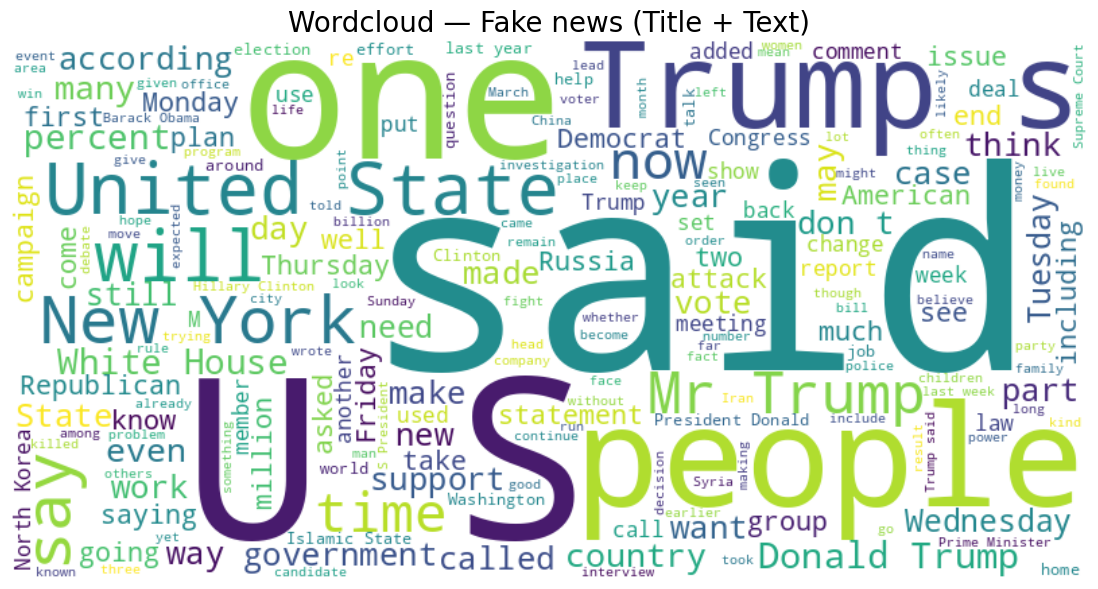

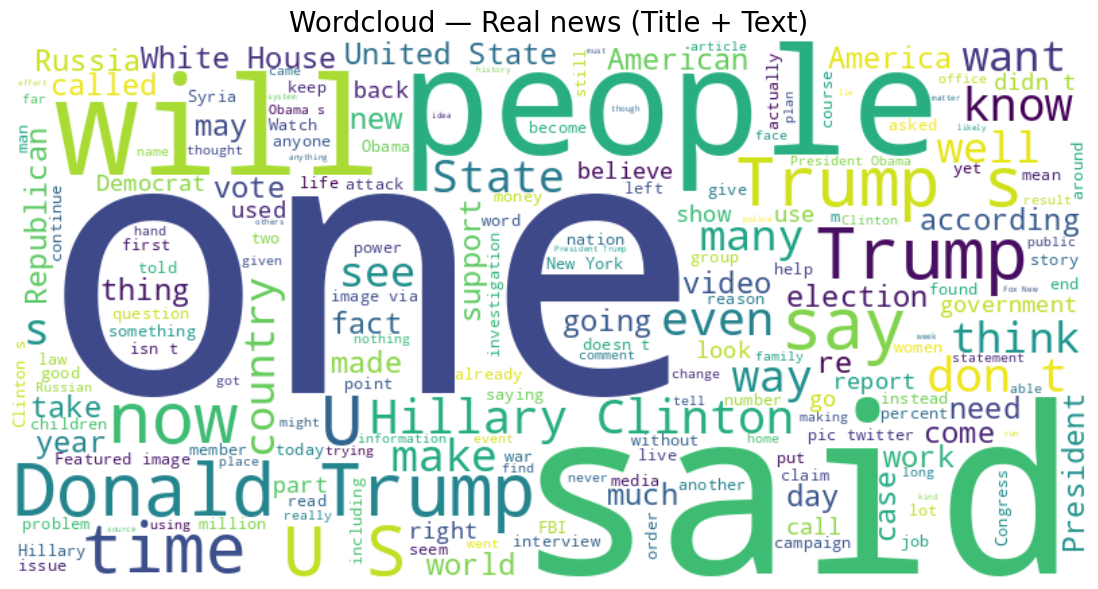

In [167]:
for label, name in [(0, "Fake"), (1, "Real")]:
    text = " ".join(str(txt) for txt in X_train[y_train==label])
    wc = WordCloud(stopwords=STOPWORDS,
                   width=800, height=400,
                   background_color='white').generate(text)
    plt.figure(figsize=(15,7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Wordcloud — {name} news (Title + Text)", fontsize=20)
    plt.axis('off')
    plt.show()

## TF-IDF Title + Text

In [168]:
X_train = [text_preprocessing(text) for text in X_train]
X_test = [text_preprocessing(text) for text in X_test]

In [169]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,     
    ngram_range=(1,2)      
)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

### 100% Data Train

In [170]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train, y_train)
    
y_pred_logistic = Logistic.predict(tfidf_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.9455188188812643


In [171]:
nb = MultinomialNB()
nb.fit(tfidf_train, y_train)

y_pred_nb = nb.predict(tfidf_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.8484785471685035


In [172]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train, y_train)

y_pred_rf = rf.predict(tfidf_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.9561932487696679


In [173]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train, y_train)

y_pred_xgb = xgb.predict(tfidf_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.954183128855618


In [174]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train, y_train)

y_pred_vote = voting.predict(tfidf_test)
print("Soft Voting Accuracy:", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy: 0.9545297012545921


#### Evaluasi

In [175]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8575587440216261
Precision: 0.8575673540273675
Recall   : 0.8575587440216261
F1-score : 0.8575346392535937

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      7043
           1       0.86      0.87      0.86      7384

    accuracy                           0.86     14427
   macro avg       0.86      0.86      0.86     14427
weighted avg       0.86      0.86      0.86     14427


=== Naive Bayes Metrics ===
Accuracy : 0.8484785471685035
Precision: 0.8490467518774928
Recall   : 0.8484785471685035
F1-score : 0.8483170001311959

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      7043
           1       0.84      0.87      0.86      7384

    accuracy                           0.85     14427
   macro avg       0.85      0.85      0.85     14427
weighted avg       0.85      0.85      0.85  

### 50% Data Train

In [176]:
tfidf_train_50, _, y_train_50, _ = train_test_split(
    tfidf_train, 
    y_train, 
    train_size=0.5,
    random_state=42,
    stratify=y_train
)

In [177]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_50, y_train_50)

y_pred = Logistic.predict(tfidf_test)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 50% data): 0.93713176682609


In [178]:
nb = MultinomialNB()
nb.fit(tfidf_train_50, y_train_50)
    
y_pred_nb = nb.predict(tfidf_test)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy (trained on 50% data): 0.8479933458099397


In [179]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_50, y_train_50)

y_pred_rf = rf.predict(tfidf_test)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 50% data): 0.9421224093713176


In [180]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_50, y_train_50)

y_pred_xgb = xgb.predict(tfidf_test)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.9503015179871075


In [181]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_50, y_train_50)

y_pred_vote = voting.predict(tfidf_test)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.9459347057600332


#### Evaluasi

In [182]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.93713176682609
Precision: 0.9372263690378345
Recall   : 0.93713176682609
F1-score : 0.9371152157693764

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      7043
           1       0.93      0.95      0.94      7384

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427


=== Naive Bayes Metrics ===
Accuracy : 0.8479933458099397
Precision: 0.8484801428877512
Recall   : 0.8479933458099397
F1-score : 0.8478463635763706

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      7043
           1       0.84      0.87      0.85      7384

    accuracy                           0.85     14427
   macro avg       0.85      0.85      0.85     14427
weighted avg       0.85      0.85      0.85     1

### 10% Data Train

In [183]:
tfidf_train_10, _, y_train_10, _ = train_test_split(
    tfidf_train, 
    y_train, 
    train_size=0.1,
    random_state=42,
    stratify=y_train
)

In [184]:
Logistic = LogisticRegression(max_iter=200)
Logistic.fit(tfidf_train_10, y_train_10)

y_pred = Logistic.predict(tfidf_test)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.9154363346503085


In [185]:
nb = MultinomialNB()
nb.fit(tfidf_train_10, y_train_10)
    
y_pred_nb = nb.predict(tfidf_test)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy (trained on 10% data): 0.8480626602897345


In [186]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(tfidf_train_10, y_train_10)

y_pred_rf = rf.predict(tfidf_test)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.9186248007208706


In [187]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(tfidf_train_10, y_train_10)

y_pred_xgb = xgb.predict(tfidf_test)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.9356761627503986


In [188]:
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(tfidf_train_10, y_train_10)

y_pred_vote = voting.predict(tfidf_test)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.928190198932557


#### Evaluasi

In [189]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.9154363346503085
Precision: 0.9159134966321724
Recall   : 0.9154363346503085
F1-score : 0.915372034839273

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      7043
           1       0.90      0.94      0.92      7384

    accuracy                           0.92     14427
   macro avg       0.92      0.91      0.92     14427
weighted avg       0.92      0.92      0.92     14427


=== Naive Bayes Metrics ===
Accuracy : 0.8480626602897345
Precision: 0.8483293304415004
Recall   : 0.8480626602897345
F1-score : 0.8479607061783369

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      7043
           1       0.84      0.87      0.85      7384

    accuracy                           0.85     14427
   macro avg       0.85      0.85      0.85     14427
weighted avg       0.85      0.85      0.85   

## BERT Title + Text

In [190]:
X_train = [text_preprocessing(text) for text in X_train]
X_test = [text_preprocessing(text) for text in X_test]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def bert_embed_batched(texts, tokenizer, model, batch_size=32, max_length=512):
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i : i + batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)
        
        with torch.no_grad():
            output = model(**encoded)
            
        token_embeddings = output.last_hidden_state
        
        attention_mask = encoded['attention_mask'].unsqueeze(-1).expand(token_embeddings.size()).float()
        
        sum_mask = torch.clamp(attention_mask.sum(1), min=1e-9)
        
        sum_embeddings = torch.sum(token_embeddings * attention_mask, 1)
        
        mean_embeddings = sum_embeddings / sum_mask
        
        all_embeddings.append(mean_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

bert_train = bert_embed_batched(X_train, tokenizer, bert_model, batch_size=32)
bert_test = bert_embed_batched(X_test, tokenizer, bert_model, batch_size=32)

Using device: cuda


Generating Embeddings: 100%|██████████| 451/451 [02:55<00:00,  2.57it/s]


### 100% Data Train

In [192]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train, y_train)
    
y_pred_logistic = Logistic.predict(bert_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.9108615789838497


In [193]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train)
bert_test_scaled = scaler.transform(bert_test)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train)
    
y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb)) 

Naive Bayes Accuracy: 0.786580716711721


In [194]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train, y_train)
    
y_pred_rf = rf.predict(bert_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.8781451445206904


In [195]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train, y_train)

y_pred_xgb = xgb.predict(bert_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy: 0.904276703403341


In [196]:
nb_pipeline = make_pipeline(MinMaxScaler(), nb)
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb_pipeline),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train, y_train)

y_pred_vote = voting.predict(bert_test)
print("Soft Voting Accuracy:", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy: 0.9139114160948222


#### Evaluasi

In [197]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.9154363346503085
Precision: 0.9159134966321724
Recall   : 0.9154363346503085
F1-score : 0.915372034839273

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91      7043
           1       0.90      0.94      0.92      7384

    accuracy                           0.92     14427
   macro avg       0.92      0.91      0.92     14427
weighted avg       0.92      0.92      0.92     14427


=== Naive Bayes Metrics ===
Accuracy : 0.786580716711721
Precision: 0.7886052471749979
Recall   : 0.786580716711721
F1-score : 0.7858844705328054

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      7043
           1       0.77      0.84      0.80      7384

    accuracy                           0.79     14427
   macro avg       0.79      0.79      0.79     14427
weighted avg       0.79      0.79      0.79     

### 50% Data Train

In [198]:
bert_train_50, _, y_train_50, _ = train_test_split(
    bert_train, 
    y_train, 
    train_size=0.5,
    random_state=42,
    stratify=y_train
)

In [199]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_50, y_train_50)

y_pred = Logistic.predict(bert_test)

print("Logistic Regression Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 50% data): 0.9086435156304152


In [200]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_50)
bert_test_scaled = scaler.transform(bert_test)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_50)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_nb)) 

Naive Bayes Accuracy (trained on 50% data): 0.786580716711721


In [201]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_50, y_train_50)

y_pred_rf = rf.predict(bert_test)
print("Random Forest Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 50% data): 0.8564497123449089


In [202]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_50, y_train_50)

y_pred_xgb = xgb.predict(bert_test)
print("XGBoost Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 50% data): 0.8965827961461149


In [203]:
nb_pipeline = make_pipeline(MinMaxScaler(), nb)
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb_pipeline),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_50, y_train_50)

y_pred_vote = voting.predict(bert_test)
print("Soft Voting Accuracy (trained on 50% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 50% data): 0.9029597282872392


#### Evaluasi

In [204]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.9086435156304152
Precision: 0.9086718096581285
Recall   : 0.9086435156304152
F1-score : 0.908628278083967

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      7043
           1       0.91      0.92      0.91      7384

    accuracy                           0.91     14427
   macro avg       0.91      0.91      0.91     14427
weighted avg       0.91      0.91      0.91     14427


=== Naive Bayes Metrics ===
Accuracy : 0.786580716711721
Precision: 0.7883035194345099
Recall   : 0.786580716711721
F1-score : 0.7859621450020456

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77      7043
           1       0.77      0.83      0.80      7384

    accuracy                           0.79     14427
   macro avg       0.79      0.79      0.79     14427
weighted avg       0.79      0.79      0.79     

### 10% Data Train

In [205]:
bert_train_10, _, y_train_10, _ = train_test_split(
    bert_train, 
    y_train, 
    train_size=0.1,
    random_state=42,
    stratify=y_train
)

In [206]:
Logistic = LogisticRegression(max_iter=1000)
Logistic.fit(bert_train_10, y_train_10)

y_pred = Logistic.predict(bert_test)

print("Logistic Regression Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy (trained on 10% data): 0.8960282803077563


In [207]:
scaler = MinMaxScaler()

bert_train_scaled = scaler.fit_transform(bert_train_10)
bert_test_scaled = scaler.transform(bert_test)

nb = MultinomialNB()
nb.fit(bert_train_scaled, y_train_10)

y_pred_nb = nb.predict(bert_test_scaled)
print("Naive Bayes Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_nb)) 

Naive Bayes Accuracy (trained on 10% data): 0.7887294655853608


In [208]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)
rf.fit(bert_train_10, y_train_10)

y_pred_rf = rf.predict(bert_test)
print("Random Forest Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy (trained on 10% data): 0.8305260969016428


In [209]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(bert_train_10, y_train_10)

y_pred_xgb = xgb.predict(bert_test)
print("XGBoost Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_xgb))

XGBoost Accuracy (trained on 10% data): 0.8710750675816178


In [210]:
nb_pipeline = make_pipeline(MinMaxScaler(), nb)
voting = VotingClassifier(
    estimators=[
        ('logistic', Logistic),
        ('nb', nb_pipeline),
        ('rf', rf),
        ('xgb', xgb)
    ],
    voting='soft'     
)

voting.fit(bert_train_10, y_train_10)

y_pred_vote = voting.predict(bert_test)
print("Soft Voting Accuracy (trained on 10% data):", accuracy_score(y_test, y_pred_vote))

Soft Voting Accuracy (trained on 10% data): 0.8796007485963818


#### Evaluasi

In [211]:
print("\n=== Logistic Regression Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\n=== Naive Bayes Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

print("\n=== Random Forest Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

print("\n=== XGBoost Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_xgb, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

print("\n=== Soft Voting Metrics ===")
print("Accuracy :", accuracy_score(y_test, y_pred_vote))
print("Precision:", precision_score(y_test, y_pred_vote, average='weighted'))
print("Recall   :", recall_score(y_test, y_pred_vote, average='weighted'))
print("F1-score :", f1_score(y_test, y_pred_vote, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_vote))


=== Logistic Regression Metrics ===
Accuracy : 0.8960282803077563
Precision: 0.896024611470635
Recall   : 0.8960282803077563
F1-score : 0.8960250503330647

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      7043
           1       0.90      0.90      0.90      7384

    accuracy                           0.90     14427
   macro avg       0.90      0.90      0.90     14427
weighted avg       0.90      0.90      0.90     14427


=== Naive Bayes Metrics ===
Accuracy : 0.7887294655853608
Precision: 0.7899325694773135
Recall   : 0.7887294655853608
F1-score : 0.7882591745084362

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78      7043
           1       0.77      0.83      0.80      7384

    accuracy                           0.79     14427
   macro avg       0.79      0.79      0.79     14427
weighted avg       0.79      0.79      0.79   